# Seminar AMS
## Rekonstrukcija manjkajočih modalitet s kontradiktornimi nevronskimi mrežami


# Priprava podatkov

## Funkcije

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import time
from os.path import join
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras as keras
#from natsort import natsorted
from tqdm import tqdm 

from amslib import resample_image
import amslib

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
def get_slice(iImg,idx):
  # Pridobim eno rezino 3D slike
  array = sitk.GetArrayFromImage(iImg) 
  array = array[:,idx,:]
  array = array[np.newaxis]
  oImg = sitk.GetImageFromArray(array)
  return oImg

def extract_image(iImg, output_size=(128, 128),  
                        crop_size = (200, 150, 1), 
                        crop_origin = (0, 0, 0),
                        interpolation_type=sitk.sitkLinear):
  #Prevzorčim in obrežem sliko
  new_spacing_mm = (crop_size[0] / output_size[0], crop_size[1] / output_size[1], 1)
  oImg = amslib.resample_image(sitk.RegionOfInterest(iImg, crop_size, crop_origin), 
                               spacing_mm = new_spacing_mm, 
                               inter_type=interpolation_type)
  return oImg

def stat_per_channel(values, stat_fcn, modality='t1'):
    if modality == 't1':
        stat = stat_fcn(np.reshape(values, (values.shape[0]*t1_HEIGHT*t1_WIDTH, t1_CHANNELS)), axis=0)[:, np.newaxis]
    elif modality == 't2':
        stat = stat_fcn(np.reshape(values, (values.shape[0]*t2_HEIGHT*t2_WIDTH, t2_CHANNELS)), axis=0)[:, np.newaxis]
    elif modality == 't1_ks':
        stat = stat_fcn(np.reshape(values, (values.shape[0]*t1_ks_HEIGHT*t1_ks_WIDTH, t1_ks_CHANNELS)), axis=0)[:, np.newaxis]
    elif modality == 'flair':
        stat = stat_fcn(np.reshape(values, (values.shape[0]*flair_HEIGHT*flair_WIDTH, flair_CHANNELS)), axis=0)[:, np.newaxis]
    elif modality == 'dir':
        stat = stat_fcn(np.reshape(values, (values.shape[0]*dir_HEIGHT*dir_WIDTH, dir_CHANNELS)), axis=0)[:, np.newaxis]
    else:
        raise ValueError('Modaliteta ni znana!')
    return stat

## Pregled vseh slik

In [4]:
t1_PATH = './data/t1'
t1_ks_PATH = './data/t1_ks'
t2_PATH = './data/t2'
flair_PATH = './data/flair'
dir_PATH = './data/dir'

In [5]:
t1_patients = os.listdir(t1_PATH)
t1_ks_patients = os.listdir(t1_ks_PATH)
t2_patients = os.listdir(t2_PATH)
flair_patients = os.listdir(flair_PATH)
dir_patients = os.listdir(dir_PATH)

print('V mapi {:s} je {:d} datotek.'.format(t1_PATH, len(t1_patients)))
print('V mapi {:s} je {:d} datotek.'.format(t1_ks_PATH, len(t1_ks_patients)))
print('V mapi {:s} je {:d} datotek.'.format(t2_PATH, len(t2_patients)))
print('V mapi {:s} je {:d} datotek.'.format(flair_PATH, len(flair_patients)))
print('V mapi {:s} je {:d} datotek.'.format(dir_PATH, len(dir_patients)))

V mapi ./data/t1 je 28 datotek.
V mapi ./data/t1_ks je 27 datotek.
V mapi ./data/t2 je 23 datotek.
V mapi ./data/flair je 28 datotek.
V mapi ./data/dir je 28 datotek.


In [6]:
print(os.listdir(t1_PATH))

['MS14_20160101_T1W.nii.gz', 'MS21_20160101_T1W.nii.gz', 'MS25_20160101_T1W.nii.gz', 'MS3_20160101_T1W.nii.gz', 'MS11_20160101_T1W.nii.gz', 'MS5_20160101_T1W.nii.gz', 'MS27_20160101_T1W.nii.gz', 'MS20_20160101_T1W.nii.gz', 'MS18_20160101_T1W.nii.gz', 'MS9_20160101_T1W.nii.gz', 'MS13_20160101_T1W.nii.gz', 'MS17_20160101_T1W.nii.gz', 'MS26_20160101_T1W.nii.gz', 'MS28_20160101_T1W.nii.gz', 'MS12_20160101_T1W.nii.gz', 'MS7_20160101_T1W.nii.gz', 'MS2_20160101_T1W.nii.gz', 'MS15_20160101_T1W.nii.gz', 'MS10_20160101_T1W.nii.gz', 'MS22_20160101_T1W.nii.gz', 'MS24_20160101_T1W.nii.gz', 'MS6_20160101_T1W.nii.gz', 'MS16_20160101_T1W.nii.gz', 'MS1_20160101_T1W.nii.gz', 'MS23_20160101_T1W.nii.gz', 'MS8_20160101_T1W.nii.gz', 'MS19_20160101_T1W.nii.gz', 'MS4_20160101_T1W.nii.gz']


## Izberem eno rezino 

In [7]:
t1_patient = join(t1_PATH)
t2_patient = join(t2_PATH)
t1_ks_patient = join(t1_ks_PATH)
flair_patient = join(flair_PATH)
dir_patient = join(dir_PATH)

t1 = sitk.ReadImage(join(t1_patient,'MS1_20160101_T1W.nii.gz'))
t2 = sitk.ReadImage(join(t2_patient,'MS1_20160101_T2W.nii.gz'))
t1_ks = sitk.ReadImage(join(t1_ks_patient,'MS1_20160101_T1WKS.nii.gz'))
flair = sitk.ReadImage(join(flair_patient,'MS1_20160101_FLAIR.nii.gz'))
mr_dir = sitk.ReadImage(join(dir_patient,'MS1_20160101_DIR.nii.gz'))

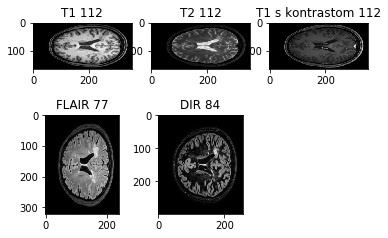

In [8]:
img_t1 = sitk.GetArrayFromImage(t1)
img_t2 = sitk.GetArrayFromImage(t2)
img_t1_ks = sitk.GetArrayFromImage(t1_ks)
img_flair = sitk.GetArrayFromImage(flair)
img_dir = sitk.GetArrayFromImage(mr_dir)

#Indeksi izbranih rezin
idx = 112 # T1, T2 in T1 s kontrastom
idx_flair = 77
idx_dir = 84
#Na izbrani rezini bom učila nevronsko mrežo
#Dimenzije slik T1, T2 in T1 s kontrastom so 352x165
#Dimenzije slik FLAIR so 240x321
#Dimenzije slik DIR so 256x300

img_t1_1 = img_t1[:,idx,:] 
img_t2_1 = img_t2[:,idx,:]
img_t1_ks_1 = img_t1_ks[:,idx,:]
img_flair_1 = img_flair[:,idx_flair,:]
img_dir_1 = img_dir[:,idx_dir,:]

plt.figure()
plt.subplot(231)
plt.title('T1 '+str(idx))
plt.imshow(img_t1_1,cmap = 'gray')

plt.subplot(232)
plt.title('T2 '+str(idx))
plt.imshow(img_t2_1,cmap = 'gray')

plt.subplot(233)
plt.title('T1 s kontrastom '+str(idx))
plt.imshow(img_t1_ks_1,cmap = 'gray')

plt.subplot(234)
plt.title('FLAIR '+str(idx_flair))
plt.imshow(img_flair_1,cmap = 'gray')

plt.subplot(235)
plt.title('DIR '+str(idx_dir))
plt.imshow(img_dir_1,cmap = 'gray')

## Uvoz slik

In [ ]:
# DOLOČIM obrezovanje in vzorčenje

import amslib
def img2array(img):
    return np.squeeze(sitk.GetArrayFromImage(img))

# Vzamem samo eno rezino iz 3D slike
img = sitk.ReadImage('MS1_20160101_T1W.nii.gz')
array = sitk.GetArrayFromImage(img)
array = array[:, idx, :][np.newaxis] # Ohranim 3 dimenzije za prevzorčenje
img = sitk.GetImageFromArray(array)
#############################
cropsize = (280,150,1)
croporigin = (50,10,0)
OUTPUT = (128,128)
#############################
# Prevzorčim in obrežem
print('Originalna velikost: ', img.GetSize())
print('Originalni korak vzorčenja: ', img.GetSpacing())
img_roi = sitk.RegionOfInterest(img, cropsize, croporigin)
print('Velikost po obrezovanju: ', img_roi.GetSize())
img_out = amslib.resample_image(img_roi, (cropsize[0]/OUTPUT[0], cropsize[1]/OUTPUT[1], 1.0))  
print('Velikost po vzorčenju: ', img_out.GetSize())
print('Korak vzorčenja: ', img_out.GetSpacing())

# Izris
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img2array(img), cmap='gray')
ax1.set_title('T1 Original')
ax1.axis('off')
ax2.imshow(img2array(img_roi), cmap='gray')
ax2.set_title('T1 Obrezana')
ax2.axis('off')
ax3.imshow(img2array(img_out), cmap='gray')
ax3.set_title('T1 Prevzorčena')
ax3.axis('off')

In [9]:
# Ustvarimo prostor za posamezno modaliteto 
t1_data = []; t2_data = []; t1_ks_data = []; flair_data = []; dir_data = []  

#Izberemo samo tiste slike, kjer imamo slike vseh petih modalitet
list=[1,4,5,6,8,10,11,12,13,14,15,16,17,18,19,20,21,23,26,27,28]

#Generiramo imena vseh slik
for i in list: 
    patient_name_t1 = 'MS'+str(i)+'_20160101_T1W.nii.gz'
    patient_name_t2 = 'MS'+str(i)+'_20160101_T2W.nii.gz'
    patient_name_t1_ks = 'MS'+str(i)+'_20160101_T1WKS.nii.gz'
    patient_name_flair = 'MS'+str(i)+'_20160101_FLAIR.nii.gz'
    patient_name_dir = 'MS'+str(i)+'_20160101_DIR.nii.gz'

 # Preberem slike  
    img_t1 = get_slice(sitk.ReadImage(join(t1_PATH,patient_name_t1)),idx)
    img_t2 = get_slice(sitk.ReadImage(join(t2_PATH,patient_name_t2)),idx)
    img_t1_ks = get_slice(sitk.ReadImage(join(t1_ks_PATH,patient_name_t1_ks)),idx)
    img_flair = get_slice(sitk.ReadImage(join(flair_PATH,patient_name_flair)),idx_flair)
    img_dir = get_slice(sitk.ReadImage(join(dir_PATH,patient_name_dir)),idx_dir)

 # Obrezovanje in prevzorčenje slik
    img_t1 = extract_image(img_t1,crop_size=(280,150,1),crop_origin=(50,10,0))
    img_t2 = extract_image(img_t2,crop_size=(280,150,1),crop_origin=(50,10,0))
    img_t1_ks = extract_image(img_t1_ks,crop_size=(280,150,1),crop_origin=(50,10,0))
    img_flair = extract_image(img_flair,crop_size=(200,280,1),crop_origin=(30,20,0))
    img_dir = extract_image(img_dir,crop_size=(200,240,1),crop_origin=(40,30,0))

    t1_data.append({'t1':img_t1}) 
    t2_data.append({'t2':img_t2}) 
    t1_ks_data.append({'t1_ks':img_t1_ks}) 
    flair_data.append({'flair':img_flair}) 
    dir_data.append({'dir':img_dir}) 

## Oblikujem 3D polja slik

In [11]:
t1_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t1'])) for data in t1_data])
print('\nVelikost T1 polja je {}'.format(t1_array.shape))
t1_array = np.transpose(t1_array,(2,0,1))
print('Velikost preoblikovanega T1 polja je {}'.format(t1_array.shape))

t2_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t2'])) for data in t2_data])
print('\nVelikost T2 polja je {}'.format(t2_array.shape))
t2_array = np.transpose(t2_array,(2,0,1))
print('Velikost preoblikovanega T2 polja je {}'.format(t2_array.shape))

t1_ks_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t1_ks'])) for data in t1_ks_data])
print('\nVelikost T1 s kontrastom polja je {}'.format(t1_ks_array.shape))
t1_ks_array = np.transpose(t1_ks_array,(2,0,1))
print('Velikost preoblikovanega T1 s kontrastom polja je {}'.format(t1_ks_array.shape))

flair_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['flair'])) for data in flair_data])
print('\nVelikost FLAIR polja je {}'.format(flair_array.shape))
flair_array = np.transpose(flair_array,(2,0,1))
print('Velikost preoblikovanega FLAIR polja je {}'.format(flair_array.shape))

dir_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['dir'])) for data in dir_data])
print('\nVelikost DIR polja je {}'.format(dir_array.shape))
dir_array = np.transpose(dir_array,(2,0,1))
print('Velikost preoblikovanega DIR polja je {}'.format(dir_array.shape))


Velikost T1 polja je (128, 128, 21)
Velikost preoblikovanega T1 polja je (21, 128, 128)

Velikost T2 polja je (128, 128, 21)
Velikost preoblikovanega T2 polja je (21, 128, 128)

Velikost T1 s kontrastom polja je (128, 128, 21)
Velikost preoblikovanega T1 s kontrastom polja je (21, 128, 128)

Velikost FLAIR polja je (128, 128, 21)
Velikost preoblikovanega FLAIR polja je (21, 128, 128)

Velikost DIR polja je (128, 128, 21)
Velikost preoblikovanega DIR polja je (21, 128, 128)


## Preoblikujem v format keras

In [12]:
print('\nKeras format: {}'.format(keras.backend.image_data_format()))

#nevronska mreža potrebuje podatke v keras formatu
if keras.backend.image_data_format() == 'channels_first':
    t1_keras_array = t1_array[:, np.newaxis, :, :] 
    t2_keras_array = t2_array[:, np.newaxis, :, :] 
    t1_ks_keras_array = t1_ks_array[:, np.newaxis, :, :] 
    flair_keras_array = flair_array[:, np.newaxis, :, :] 
    dir_keras_array = dir_array[:, np.newaxis, :, :] 
else:
    t1_keras_array = t1_array[:, :, :, np.newaxis]
    t2_keras_array = t2_array[:, :, :, np.newaxis]
    t1_ks_keras_array = t1_ks_array[:, :, :, np.newaxis]
    flair_keras_array = flair_array[:, :, :, np.newaxis]
    dir_keras_array = dir_array[:, :, :, np.newaxis]

print('\nVelikost T1 polja je {}'.format(t1_keras_array.shape))
print('\nVelikost T2 polja je {}'.format(t2_keras_array.shape))
print('\nVelikost T1 s kontrastom polja je {}'.format(t1_ks_keras_array.shape))
print('\nVelikost FLAIR polja je {}'.format(flair_keras_array.shape))
print('\nVelikost DIR polja je {}'.format(dir_keras_array.shape))


Keras format: channels_last

Velikost T1 polja je (21, 128, 128, 1)

Velikost T2 polja je (21, 128, 128, 1)

Velikost T1 s kontrastom polja je (21, 128, 128, 1)

Velikost FLAIR polja je (21, 128, 128, 1)

Velikost DIR polja je (21, 128, 128, 1)


## Normaliziram sivinske vrednosti slik

In [13]:
_, t1_HEIGHT, t1_WIDTH, t1_CHANNELS = t1_keras_array.shape
_, t2_HEIGHT, t2_WIDTH, t2_CHANNELS = t2_keras_array.shape
_, t1_ks_HEIGHT, t1_ks_WIDTH, t1_ks_CHANNELS = t1_ks_keras_array.shape
_, flair_HEIGHT, flair_WIDTH, flair_CHANNELS = flair_keras_array.shape
_, dir_HEIGHT, dir_WIDTH, dir_CHANNELS = dir_keras_array.shape


# Izračunaj mejne sivinske vrednosti
min_t1_keras_array, max_t1_keras_array = stat_per_channel(t1_keras_array, np.min), stat_per_channel(t1_keras_array, np.max)
min_t2_keras_array, max_t2_keras_array = stat_per_channel(t2_keras_array, np.min), stat_per_channel(t2_keras_array, np.max)
min_t1_ks_keras_array, max_t1_ks_keras_array = stat_per_channel(t1_ks_keras_array, np.min), stat_per_channel(t1_ks_keras_array, np.max)
min_flair_keras_array, max_flair_keras_array = stat_per_channel(flair_keras_array, np.min), stat_per_channel(flair_keras_array, np.max)
min_dir_keras_array, max_dir_keras_array = stat_per_channel(dir_keras_array, np.min), stat_per_channel(dir_keras_array, np.max)

print('\nObmočje sivinskih vrednosti pred normalizacijo:')
print('\tt1_min: {}'.format(min_t1_keras_array.flatten()))
print('\tt1_max:{}'.format(max_t1_keras_array.flatten()))
print('\tt2_min: {}'.format(min_t2_keras_array.flatten()))
print('\tt2_max:{}'.format(max_t2_keras_array.flatten()))
print('\tt1_ks_min: {}'.format(min_t1_ks_keras_array.flatten()))
print('\tt1_ks_max:{}'.format(max_t1_ks_keras_array.flatten()))
print('\tflair_min: {}'.format(min_flair_keras_array.flatten()))
print('\tflair_max:{}'.format(max_dir_keras_array.flatten()))
print('\tdir_min: {}'.format(min_flair_keras_array.flatten()))
print('\tdir_max:{}'.format(max_dir_keras_array.flatten()))
      

min_t1_keras_array = np.reshape(min_t1_keras_array, (1, 1, 1, t1_CHANNELS)) 
max_t1_keras_array = np.reshape(max_t1_keras_array, (1, 1, 1, t1_CHANNELS))
min_t2_keras_array = np.reshape(min_t2_keras_array, (1, 1, 1, t2_CHANNELS))
max_t2_keras_array = np.reshape(max_t2_keras_array, (1, 1, 1, t2_CHANNELS))
min_t1_ks_keras_array = np.reshape(min_t1_ks_keras_array, (1, 1, 1, t1_ks_CHANNELS))
max_t1_ks_keras_array = np.reshape(max_t1_ks_keras_array, (1, 1, 1, t1_ks_CHANNELS))
min_flair_keras_array = np.reshape(min_flair_keras_array, (1, 1, 1, flair_CHANNELS))
max_flair_keras_array = np.reshape(max_flair_keras_array, (1, 1, 1, flair_CHANNELS))
min_dir_keras_array = np.reshape(min_dir_keras_array, (1, 1, 1, dir_CHANNELS))
max_dir_keras_array = np.reshape(max_dir_keras_array, (1, 1, 1, dir_CHANNELS))

# Normaliziraj vhodne slike 
t1_norm = (t1_keras_array - min_t1_keras_array) / (max_t1_keras_array - min_t1_keras_array)
t2_norm = (t2_keras_array - min_t2_keras_array) / (max_t2_keras_array - min_t2_keras_array)
t1_ks_norm = (t1_ks_keras_array - min_t1_ks_keras_array) / (max_t1_ks_keras_array - min_t1_ks_keras_array)
flair_norm = (flair_keras_array - min_flair_keras_array) / (max_flair_keras_array - min_flair_keras_array)
dir_norm = (dir_keras_array - min_dir_keras_array) / (max_dir_keras_array - min_dir_keras_array)
      
min_t1_keras_array, max_t1_keras_array = stat_per_channel(t1_norm, np.min), stat_per_channel(t1_norm, np.max)
min_t2_keras_array, max_t2_keras_array = stat_per_channel(t2_norm, np.min), stat_per_channel(t2_norm, np.max)
min_t1_ks_keras_array, max_t1_ks_keras_array = stat_per_channel(t1_ks_norm, np.min), stat_per_channel(t1_ks_norm, np.max)
min_flair_keras_array, max_flair_keras_array = stat_per_channel(flair_norm, np.min), stat_per_channel(flair_norm, np.max)
min_dir_keras_array, max_dir_keras_array = stat_per_channel(dir_norm, np.min), stat_per_channel(dir_norm, np.max)

print('\nObmočje sivinskih vrednosti pred normalizacijo:')
print('\tt1_min: {}'.format(min_t1_keras_array.flatten()))
print('\tt1_max:{}'.format(max_t1_keras_array.flatten()))
print('\tt2_min: {}'.format(min_t2_keras_array.flatten()))
print('\tt2_max:{}'.format(max_t2_keras_array.flatten()))
print('\tt1_ks_min: {}'.format(min_t1_ks_keras_array.flatten()))
print('\tt1_ks_max:{}'.format(max_t1_ks_keras_array.flatten()))
print('\tflair_min: {}'.format(min_flair_keras_array.flatten()))
print('\tflair_max:{}'.format(max_dir_keras_array.flatten()))
print('\tdir_min: {}'.format(min_flair_keras_array.flatten()))


Območje sivinskih vrednosti pred normalizacijo:
	t1_min: [0]
	t1_max:[2105]
	t2_min: [0]
	t2_max:[2426]
	t1_ks_min: [0]
	t1_ks_max:[2411]
	flair_min: [0]
	flair_max:[3049]
	dir_min: [0]
	dir_max:[3049]

Območje sivinskih vrednosti pred normalizacijo:
	t1_min: [0.]
	t1_max:[1.]
	t2_min: [0.]
	t2_max:[1.]
	t1_ks_min: [0.]
	t1_ks_max:[1.]
	flair_min: [0.]
	flair_max:[1.]
	dir_min: [0.]


## Ustvarim prave direktorije

In [15]:
# Slike za učenje
modalities = ['t1','t2','t1_ks','flair','dir']
for subject in tqdm(range(1,14)):
  DATA_PATH = './Dataset-name'
  subject_dir = 'trainS'+str(subject)
  os.chdir(DATA_PATH)
  os.mkdir(subject_dir)
  filePath = subject_dir
  os.chdir(filePath)
    
  for mod in modalities:
    filename = mod + '.nii.gz'
    if mod == 't1':
      tmp = sitk.GetImageFromArray(t1_norm[subject,:,:,:]) 
    elif mod == 't2':
      tmp = sitk.GetImageFromArray(t2_norm[subject,:,:,:])
    elif mod == 't1_ks':
      tmp = sitk.GetImageFromArray(t1_ks_norm[subject,:,:,:])
    elif mod == 'flair':
      tmp = sitk.GetImageFromArray(flair_norm[subject,:,:,:])
    elif mod == 'dir':
      tmp = sitk.GetImageFromArray(dir_norm[subject,:,:,:])
    else:
      raise ValueError('Ni te modalitete!')
    sitk.WriteImage(tmp, filename)
  #os.chdir(os.path.dirname(DATA_PATH))
  os.chdir('..') #en dir gor
  os.chdir('..')


  0%|          | 0/13 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './Dataset-name'

In [ ]:
# Slike za učenje
os.mkdir('./Dataset-name')
modalities = ['t1','t2','t1_ks','flair','dir']
for subject in tqdm(range(15,21)):
  DATA_PATH = './Dataset-name'
  subject_dir = 'testS'+str(subject)
  os.chdir(DATA_PATH)
  os.mkdir(subject_dir)
  filePath = subject_dir
  os.chdir(filePath)
    
  for mod in modalities:
    filename = mod + '.nii.gz'
    if mod == 't1':
      tmp = sitk.GetImageFromArray(t1_norm[subject,:,:,:]) 
    elif mod == 't2':
      tmp = sitk.GetImageFromArray(t2_norm[subject,:,:,:])
    elif mod == 't1_ks':
      tmp = sitk.GetImageFromArray(t1_ks_norm[subject,:,:,:])
    elif mod == 'flair':
      tmp = sitk.GetImageFromArray(flair_norm[subject,:,:,:])
    elif mod == 'dir':
      tmp = sitk.GetImageFromArray(dir_norm[subject,:,:,:])
    else:
      raise ValueError('Ni te modalitete!')
    sitk.WriteImage(tmp, filename)
  #os.chdir(os.path.dirname(DATA_PATH))
  os.chdir('..') #en dir gor
  os.chdir('..')

# Učenje nevronske mreže

In [16]:
%pwd
%cd /home/jagodicspela/Seminar

/home/jagodicspela/Seminar


In [ ]:
from instancenormalization import InstanceNormalization 

In [17]:
import train as dg
novGAN = dg.DiamondGAN()
model = novGAN.ime_funkcije()

Instructions for updating:
Colocations handled automatically by placer.
--- Caching data ---


NameError: name 'load_data' is not defined